In [1]:
using Optim, LsqFit
using Plots, LaTeXStrings
using DelimitedFiles
using Statistics
using DataFrames
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
function print_fit_values(fit, par0, par_names)
    println(@sprintf "RSS = %.5f (convergence: %s)" sum(abs2, fit.resid) fit.converged)
    for i in 1:length(par0)
        name = par_names[i]
        val = fit.param[i]
        CIl = confidence_interval(fit, 0.05)[i][1]
        CIr = confidence_interval(fit, 0.05)[i][2]
        p0 = par0[i]
        println(@sprintf "  %s = %.3e (CI=(%.3e, %.3e), initial=%.3e)" name val CIl CIr p0)
    end
end

print_fit_values (generic function with 1 method)

# Viral load data fitting

Data for influenza from

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


## Data set

10 mice with 13 data points each

In [4]:
tdata = Array(range(0., 12. , step=1.0))
data = readdlm("../../data/Smith2018/Virus_Best10.txt", ' ', Float64, '\n')
DataFrame(data, Symbol.(0.:12.))

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,4.18551,5.67816,6.00515,5.9364,5.97712,5.44716,5.19848,4.00515,0.0,0.0,0.0,0.0
2,0.0,3.99136,5.47712,5.84488,5.82436,5.81012,5.0874,4.49136,0.0,0.0,0.0,0.0,0.0
3,0.0,3.49136,5.44716,5.81012,5.83815,5.78016,5.2954,5.01851,2.94716,0.0,0.0,0.0,0.0
4,0.0,3.29788,5.77233,6.24612,5.49136,5.9624,5.14412,5.51851,3.23882,0.0,0.0,0.0,0.0
5,0.0,4.75515,5.9624,6.44716,5.78016,5.83244,5.99136,4.96982,0.0,0.0,0.0,0.0,0.0
6,0.0,4.30151,5.49136,6.86448,5.70812,5.80282,4.9624,4.47712,0.0,0.0,0.0,0.0,0.0
7,0.0,3.49136,5.7954,5.74951,6.03148,5.82436,5.2954,5.17215,3.26036,0.0,0.0,0.0,0.0
8,0.0,4.00515,6.03148,5.83815,6.26036,6.1294,5.18551,4.83815,0.0,0.0,0.0,0.0,0.0
9,0.0,3.49136,6.18551,5.78784,5.59921,5.97712,5.34488,5.47712,0.0,0.0,0.0,0.0,0.0


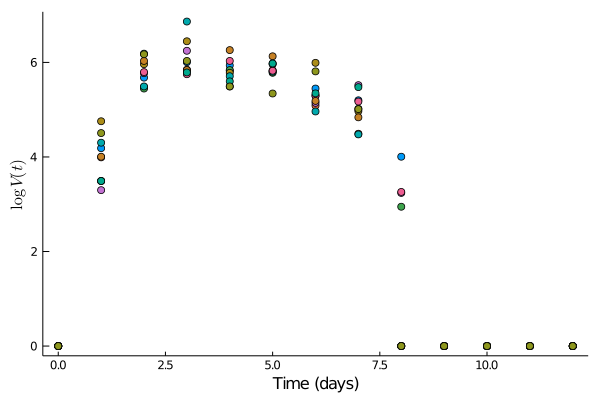

In [5]:
plt = plot(legend=:none, grid=:none, xlabel="Time (days)", ylabel=L"\log\,V(t)")
[plot!(tdata, data[i, :], seriestype=:scatter) for i in 1:size(data, 1)]
plt

### Using combined data

In [6]:
ttdata = repeat(tdata, inner=10)
tend = ttdata[end]
vvdata = reshape(data, 1, :)[:];

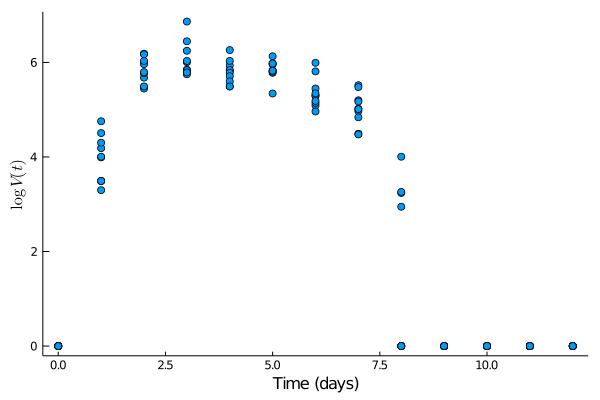

In [7]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

## Standard virus load function

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

### Chanlenges fitting this function

- The parameter $V_{\min}$ is particularly difficult to deal with because is smaller than reasonable steps length, causing $v_3(t)$ to become negative.

  Solutions to this problem:

  - Fix the value of $V_{\min}$.
  - Rescale $V_{\min}$, i.e., $V_{\min} = 10^{\tilde V_{\min}}$. **Implemented here.**
  - Restrict the step length, but convergence would take much longer. This could be done via `LineSearches.jl`.

- A similar issue occurs with $V_{\max}$, the scale is this parameter is very large compared to the rest.
  
  Solutions to this problem:
  
  - Fix the value of $V_{\max}$.
  - Rescale $V_{\max}$, i.e., $V_{\max} = 10^{\tilde V_{\min}}$. **Implemented here.**
  - Include weights. This could be done via `LsqFit.jl`

- The initial guess and lower and upper bounds are tricky to choose. First, because far from initial conditions we could have violation of $a_1<a_2<b_1<b_2$, hence negative $V(t)$; and second, if we impose bounds forcing this condition it is easy to hit the bounds when optimizing.

- Standard error are sometime large.

- Data usually has a threshold of bwloe which all counts are given the same value. For example, points equal to $0$ from time $t=8$ to $t=12$ in the sata set above.

**Using the rescaling $V_{\min}$ and $V_{\max}$ seems to be the better solution for the first three problems above.**

**Forcing the function to be equal to a threshold $\theta$ when the value of the function drops below that value. For that we define the empirical virus load function.**

$$
L V_{\theta}(t) = \max( \log V(t), \theta).
$$

In [8]:
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
v₁(t, a₁, a₂, logVmax) = 1. + (10^logVmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/(a₂ - a₁)))/2
v₂(t, a₂, α) = 1. - heaviside(t - a₂) + heaviside(t - a₂)*exp(-α*(t - a₂))
v₃(t, b₁, b₂, logVmin) = 1. - (1.0 - 10^logVmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/(b₂ - b₁)))/2
function LogVirusLoad(t, p)
    θ = minimum(vvdata)
    logVmin = -6.0
    a₁, a₂, b₁, b₂, α, logVmax = p
    logV = log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
    max.(logV, θ)
end
par_names = ["a₁", "a₂", "b₁", "b₂", "α", "logVmax"];

## Optimizations methods

### Levenberg-Marquardt via `LsqFit.jl`
It is particularly hard to choose initial values and lower and upper bounds

In [9]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit = curve_fit(LogVirusLoad, ttdata, vvdata, par0, lower=lb, upper=ub)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([0.7722333214860755, 3.1612139518324853, 6.379682375820029, 7.726057611461916, 0.5032046701100988, 6.066867262137789], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], true, Float64[])

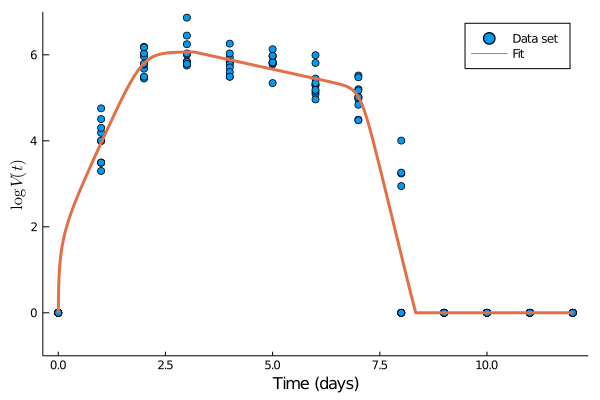

In [10]:
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad(tt, fit.param)
pt = plot(ttdata, vvdata, 
    label="Data set", seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    grid=:off, label="Fit",
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
savefig(figdir*"Smith2018VLFDataFit.png")
savefig(figdir*"Smith2018VLFDataFit.pdf")
display(pt)

In [11]:
print_fit_values(fit, par0, par_names)

RSS = 35.26169 (convergence: true)
  a₁ = 7.722e-01 (CI=(5.427e-01, 1.002e+00), initial=7.000e-01)
  a₂ = 3.161e+00 (CI=(2.411e+00, 3.912e+00), initial=2.880e+00)
  b₁ = 6.380e+00 (CI=(5.845e+00, 6.914e+00), initial=6.000e+00)
  b₂ = 7.726e+00 (CI=(7.509e+00, 7.943e+00), initial=7.600e+00)
  α = 5.032e-01 (CI=(8.278e-02, 9.236e-01), initial=2.000e-01)
  logVmax = 6.067e+00 (CI=(5.817e+00, 6.316e+00), initial=5.000e+00)


## Exploration

In the following, we try different ideas and approches.

### Box constrains with Conjugate Gradient via `Optim.jl` 
Just for the sake of comparisson, let's use anothe numerical method different to Levenberg-Marquart. In this case, we use interior points with Conjugate Gradient which does not require first derivative information. (Note that the empirical virus load function is not differentiable with repec to the parameters since it involves the maximum functions.)

In [12]:
res(p) = sum(abs2, LogVirusLoad(ttdata, p) - vvdata)

res (generic function with 1 method)

Convergence is faster and appears to be slightly better (smaller RSS) that with the previous method.

In [13]:
fit2 = optimize(res, par0, NelderMead())

 * Status: success

 * Candidate solution
    Final objective value:     3.526169e+01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    368
    f(x) calls:    623


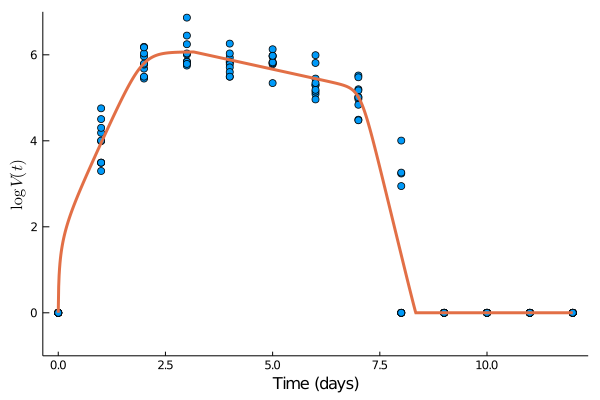

In [14]:
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad(tt, Optim.minimizer(fit2))
plot(ttdata, vvdata, seriestype=:scatter)
plot!(tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

Same optimizer as before.

In [15]:
Optim.minimizer(fit2)

6-element Array{Float64,1}:
 0.7722400992624028
 3.1611855293323696
 6.379663952438335
 7.726055950962424
 0.5031933823130073
 6.0668588208521195

However, the package `Optim.jl` does not provide with standard error. They have to be computed separately.

### Combined data without the last three observations

All observation equal to zero (the threshold $\theta$ for this data set) represent any measurement below the threshold. Thus, increasing or decreasing the number of observations below the threshold should not affect the best fit. this time we'll remove the last three observations.

In [16]:
ttdata = repeat(tdata[1:end-3], inner=10)
tend = ttdata[end]
vvdata = reshape(data[:, 1:end-3], 1, :)[:];

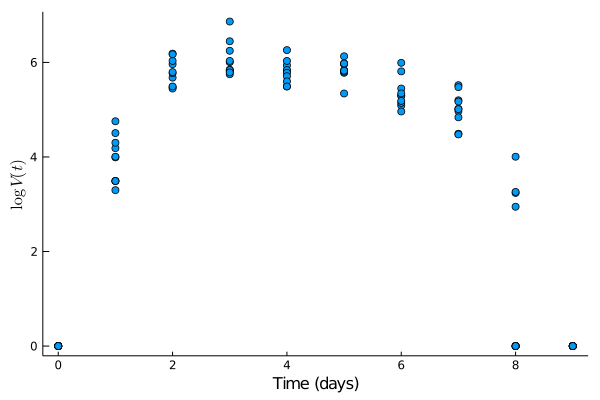

In [17]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xaxis=("Time (days)"), yaxis=(L"\log\,V(t)"))

Same initial conditions as in the first case

In [18]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit = curve_fit(LogVirusLoad, ttdata, vvdata, par0, lower=lb, upper=ub)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([0.7722333214156404, 3.161213952549583, 6.3796823762019885, 7.726057611637759, 0.5032046705000639, 6.066867262267084], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], true, Float64[])

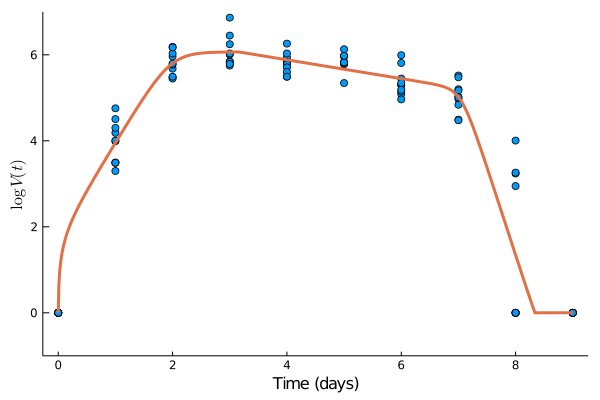

In [19]:
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad(tt, fit.param)
plot(ttdata, vvdata, seriestype=:scatter)
plot!(tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

In [20]:
print_fit_values(fit, par0, par_names)

RSS = 35.26169 (convergence: true)
  a₁ = 7.722e-01 (CI=(5.077e-01, 1.037e+00), initial=7.000e-01)
  a₂ = 3.161e+00 (CI=(2.297e+00, 4.026e+00), initial=2.880e+00)
  b₁ = 6.380e+00 (CI=(5.764e+00, 6.996e+00), initial=6.000e+00)
  b₂ = 7.726e+00 (CI=(7.476e+00, 7.976e+00), initial=7.600e+00)
  α = 5.032e-01 (CI=(1.881e-02, 9.876e-01), initial=2.000e-01)
  logVmax = 6.067e+00 (CI=(5.779e+00, 6.354e+00), initial=5.000e+00)


This is the same best fit as before.
```
RSS = 35.26169 (convergence: true)
  a₁ = 7.722e-01 (CI=(5.427e-01, 1.002e+00), initial=7.000e-01)
  a₂ = 3.161e+00 (CI=(2.411e+00, 3.912e+00), initial=2.880e+00)
  b₁ = 6.380e+00 (CI=(5.845e+00, 6.914e+00), initial=6.000e+00)
  b₂ = 7.726e+00 (CI=(7.509e+00, 7.943e+00), initial=7.600e+00)
  α = 5.032e-01 (CI=(8.278e-02, 9.236e-01), initial=2.000e-01)
  logVmax = 6.067e+00 (CI=(5.817e+00, 6.316e+00), initial=5.000e+00)
```

## Changing the value of $V_{min}$

Does the choice of $V_{min}$ effect the best fit? For this, we redefine the function and try different values $V_{min}=-4$, $-10$,  and $-14$.

In [21]:
ttdata = repeat(tdata, inner=10)
tend = ttdata[end]
vvdata = reshape(data, 1, :)[:];

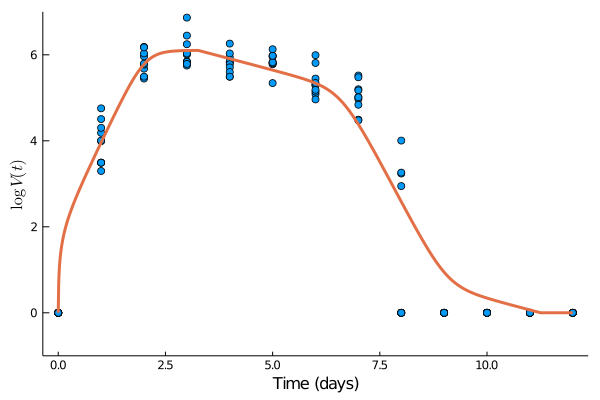

RSS = 64.88376 (convergence: false)
  a₁ = 7.755e-01 (CI=(4.538e-01, 1.097e+00), initial=7.000e-01)
  a₂ = 3.265e+00 (CI=(2.467e+00, 4.063e+00), initial=2.880e+00)
  b₁ = 5.000e+00 (CI=(4.140e+00, 5.860e+00), initial=6.000e+00)
  b₂ = 8.202e+00 (CI=(7.911e+00, 8.494e+00), initial=7.600e+00)
  α = 6.064e-01 (CI=(4.487e-01, 7.640e-01), initial=2.000e-01)
  logVmax = 6.103e+00 (CI=(5.843e+00, 6.364e+00), initial=5.000e+00)


In [22]:
function LogVirusLoad(t, p)
    θ = minimum(vvdata)
    logVmin = -4.0
    a₁, a₂, b₁, b₂, α, logVmax = p
    logV = log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
    max.(logV, θ)
end
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit = curve_fit(LogVirusLoad, ttdata, vvdata, par0, lower=lb, upper=ub)
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad(tt, fit.param)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
display(pt)
print_fit_values(fit, par0, par_names)

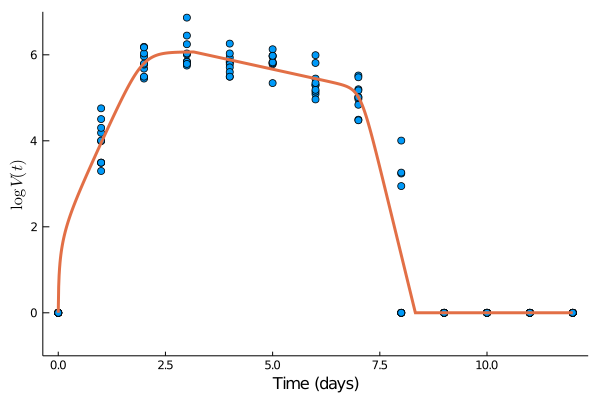

RSS = 35.26169 (convergence: true)
  a₁ = 7.722e-01 (CI=(5.427e-01, 1.002e+00), initial=7.000e-01)
  a₂ = 3.161e+00 (CI=(2.411e+00, 3.912e+00), initial=2.880e+00)
  b₁ = 6.379e+00 (CI=(5.844e+00, 6.915e+00), initial=6.000e+00)
  b₂ = 7.726e+00 (CI=(7.510e+00, 7.943e+00), initial=7.600e+00)
  α = 5.032e-01 (CI=(8.278e-02, 9.236e-01), initial=2.000e-01)
  logVmax = 6.067e+00 (CI=(5.817e+00, 6.316e+00), initial=5.000e+00)


In [23]:
function LogVirusLoad(t, p)
    θ = minimum(vvdata)
    logVmin = -10.0
    a₁, a₂, b₁, b₂, α, logVmax = p
    logV = log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
    max.(logV, θ)
end
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit = curve_fit(LogVirusLoad, ttdata, vvdata, par0, lower=lb, upper=ub)
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad(tt, fit.param)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
display(pt)
print_fit_values(fit, par0, par_names)

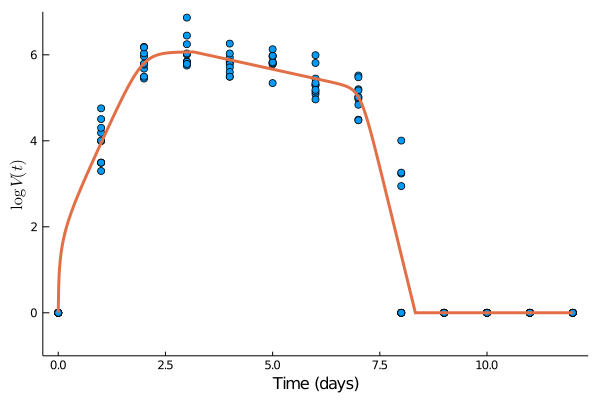

RSS = 35.26169 (convergence: true)
  a₁ = 7.722e-01 (CI=(5.427e-01, 1.002e+00), initial=7.000e-01)
  a₂ = 3.161e+00 (CI=(2.411e+00, 3.912e+00), initial=2.880e+00)
  b₁ = 6.379e+00 (CI=(5.844e+00, 6.915e+00), initial=6.000e+00)
  b₂ = 7.726e+00 (CI=(7.510e+00, 7.943e+00), initial=7.600e+00)
  α = 5.032e-01 (CI=(8.278e-02, 9.236e-01), initial=2.000e-01)
  logVmax = 6.067e+00 (CI=(5.817e+00, 6.316e+00), initial=5.000e+00)


In [24]:
function LogVirusLoad(t, p)
    θ = minimum(vvdata)
    logVmin = -14.0
    a₁, a₂, b₁, b₂, α, logVmax = p
    logV = log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
    max.(logV, θ)
end
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit = curve_fit(LogVirusLoad, ttdata, vvdata, par0, lower=lb, upper=ub)
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad(tt, fit.param)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
display(pt)
print_fit_values(fit, par0, par_names)

Compare these results with the original best fit
```
RSS = 35.26169 (convergence: true)
  a₁ = 7.722e-01 (CI=(5.427e-01, 1.002e+00), initial=7.000e-01)
  a₂ = 3.161e+00 (CI=(2.411e+00, 3.912e+00), initial=2.880e+00)
  b₁ = 6.380e+00 (CI=(5.845e+00, 6.914e+00), initial=6.000e+00)
  b₂ = 7.726e+00 (CI=(7.509e+00, 7.943e+00), initial=7.600e+00)
  α = 5.032e-01 (CI=(8.278e-02, 9.236e-01), initial=2.000e-01)
  logVmax = 6.067e+00 (CI=(5.817e+00, 6.316e+00), initial=5.000e+00)
```
For $\log V_{min}=-4$ the fit is not good, but for $\log V_{min}<-6$ the fit is basically the same.

## Non-empirical Virus Load Function

Now let's use the virus load function without taking into account the threshold, that is without forcing the maximum value between the function and the threshold.

With all data points. The value of $\alpha$ is too small.

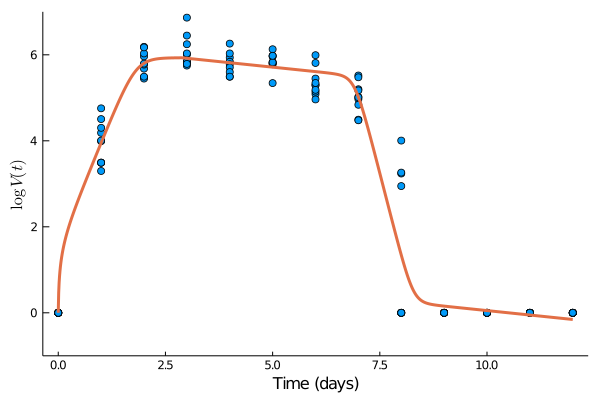

RSS = 36.34237 (convergence: true)
  a₁ = 7.405e-01 (CI=(5.045e-01, 9.766e-01), initial=7.000e-01)
  a₂ = 2.882e+00 (CI=(1.925e+00, 3.839e+00), initial=2.880e+00)
  b₁ = 6.226e+00 (CI=(5.939e+00, 6.512e+00), initial=6.000e+00)
  b₂ = 7.606e+00 (CI=(7.468e+00, 7.743e+00), initial=7.600e+00)
  α = 2.380e-01 (CI=(-1.042e-02, 4.864e-01), initial=2.000e-01)
  logVmin = -5.145e+00 (CI=(-5.835e+00, -4.454e+00), initial=-6.000e+00)
  logVmax = 5.932e+00 (CI=(5.723e+00, 6.141e+00), initial=5.000e+00)


In [25]:
function LogVirusLoad(t, p)
    a₁, a₂, b₁, b₂, α, logVmin, logVmax = p
    log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
end
par_names = ["a₁", "a₂", "b₁", "b₂", "α", "logVmin", "logVmax"];
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, -6.00, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, -12.0, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, -2.00, 7.0]
fit = curve_fit(LogVirusLoad, ttdata, vvdata, par0, lower=lb, upper=ub)
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad(tt, fit.param)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
display(pt)
print_fit_values(fit, par0, par_names)

Now removing the last three observations. The result is the same as in the case of empirical virus load function.

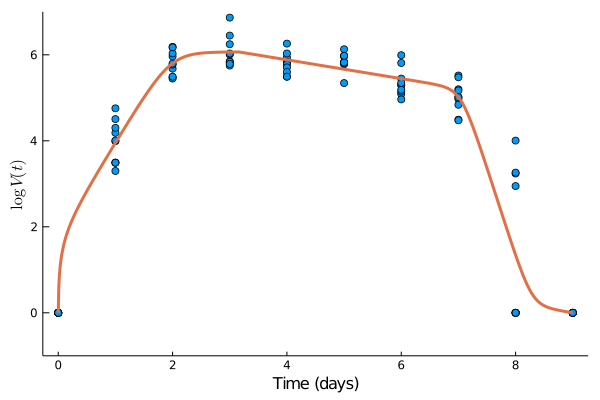

RSS = 35.26169 (convergence: true)
  a₁ = 7.722e-01 (CI=(5.063e-01, 1.038e+00), initial=7.000e-01)
  a₂ = 3.161e+00 (CI=(2.292e+00, 4.031e+00), initial=2.880e+00)
  b₁ = 6.385e+00 (CI=(5.769e+00, 7.000e+00), initial=6.000e+00)
  b₂ = 7.720e+00 (CI=(7.471e+00, 7.969e+00), initial=7.600e+00)
  α = 5.032e-01 (CI=(1.616e-02, 9.903e-01), initial=2.000e-01)
  logVmin = -4.792e+00 (CI=(-5.792e+00, -3.791e+00), initial=-6.000e+00)
  logVmax = 6.067e+00 (CI=(5.778e+00, 6.356e+00), initial=5.000e+00)


In [26]:
ttdata = repeat(tdata[1:end-3], inner=10)
tend = ttdata[end]
vvdata = reshape(data[:, 1:end-3], 1, :)[:];
fit = curve_fit(LogVirusLoad, ttdata, vvdata, par0, lower=lb, upper=ub)
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad(tt, fit.param)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
display(pt)
print_fit_values(fit, par0, par_names)

**As we can see,the empirical virus load function is more adequate for data.**

## Figures for the paper

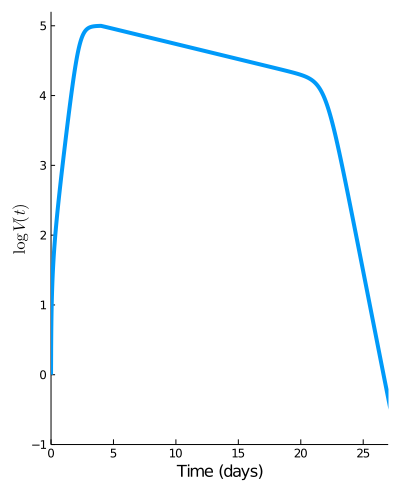

In [27]:
tend = 40.
par = [0.5,
       4.0,
       19.0,
       25.0,
       0.1,
       -6.0,
       5.0]
tt = Vector(range(0., tend, step=1e-2))
vv = LogVirusLoad(tt, par)
pt = plot(tt, vv, lw=4,
    legend=:none, grid=:off, size=(400, 500),
    xaxis = ("Time (days)", (0., 27.)),
    yaxis = (L"$\log\, V(t)$", (-1, 5.2)))
savefig("figures/VirusLoadLog.pdf")
savefig("figures/VirusLoadLog.png")
display(pt)

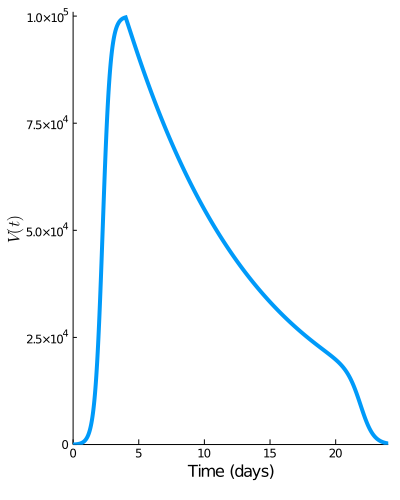

In [28]:
pt = plot(tt, 10.0.^vv, lw=4,
    legend=:none, grid=:off, size=(400, 500),
    xaxis = ("Time (days)", (0., 24.)),
    yaxis = (L"$V(t)$", (0, 1.01e5)))
savefig("figures/VirusLoad.pdf")
savefig("figures/VirusLoad.png")
display(pt)